In [1]:
## Jupyter notebook for demonstrate calculation of 1 dimensional shocks in ejector mixers with simpy_ejector package
## copyright: Adam Buruzs (aburuzs@gmail.com)

In [2]:
import logging
import sys
logging.basicConfig(stream = sys.stdout, level = logging.INFO)

In [3]:
from simpy_ejector import nozzleFactory, NozzleParams, nozzleSolver, EjectorGeom, refProp, EjectorMixer

In [5]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import time
import importlib
import math

%matplotlib notebook

from IPython.display import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))
from time import time
t0 = time()
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', 140)
np.core.arrayprint._line_width = 180
np.set_printoptions(linewidth= 180)

C:\Users\BuruzsA\AppData\Local\Temp\ipykernel_2024\2667008842.py:13: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


<IPython.core.display.Javascript object>


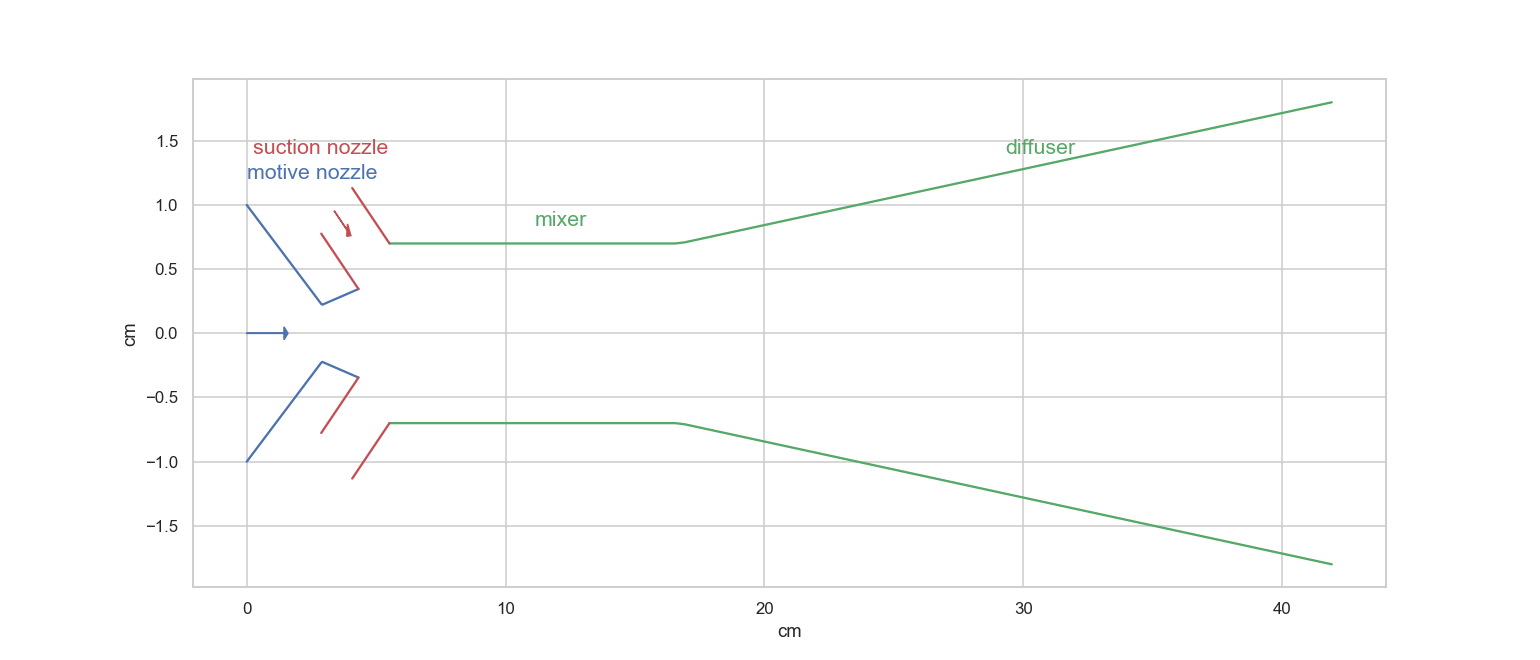

(506.9107805465337, 664.5136471770934)

In [6]:
nozzle = nozzleFactory.ConicConic(Rin = 1.0, Lcon=2.905, Rt = 0.2215, Ldiv = 1.4116, Rout = 0.345 )
nozzle.setFriction( 1.0e-2 )
ejector = EjectorGeom(nozzle, Dm = 1.4 )
ejector.setMixer(mixerstart=5.514, mixerLen=11.2, diffuserLen=25.2, diffuserHeight=1.80)
ejectorPlot = ejector.draw()
## Butane ejector for heat pump see Schlemminger article
pin = 2140.0  # kPa  2000
Tin = 273.15 + 114.0  # Kelvin  380
Tsuc =  52.7 + 273.15 #  suction temperature
Psuc =  430 # suction pressure kPa
fluid = "BUTANE"
RP = refProp.setup(fluid)
[Din, hin] = refProp.getDh_from_TP(RP, Tin, pin)
[DinSuc, hinSuc] = refProp.getDh_from_TP(RP, Tsuc, Psuc)
hin, hinSuc

## Calculating primary nozzle mass flow rate, and critical flow speed

In [7]:
nsolver = nozzleSolver.NozzleSolver(nozzle, fluid, 1, solver="AdamAdaptive", mode="basic")
nsolver.setFriction(1e-2)
vin_crit = nsolver.calcCriticalSpeed(pin, hin, 0.1, maxdev= 1e-3, chokePos="divergent_part" )
vin_crit

friction of the flow calc set to 0.01
{'massflow': 0.04155902420093311}
INFO:root: x interval end reached xlast 4.300000000000001 +  dX 0.1 vs xend 4.316599999999999
INFO:root:solver finished in 45 iterations. final point xlast =4.316599999999999
{'massflow': 0.08311804840186622}
INFO:root: x interval end reached xlast 4.30064886355073 +  dX 0.0375162215887682 vs xend 4.316599999999999
INFO:root:solver finished in 70 iterations. final point xlast =4.316599999999999
{'massflow': 0.16623609680373244}
INFO:root: x interval end reached xlast 4.316275371540608 +  dX 0.009084710169361743 vs xend 4.316599999999999
INFO:root:solver finished in 200 iterations. final point xlast =4.316599999999999
1.2
{'massflow': 0.3324721936074649}
3 dimensional Newton Raphson has not converged in 100 iterations
error = 6.170034974023864
INFO:root:Newton root finding failed at 2.6247212474664194 + 0.0001477481131599897
3 dimensional Newton Raphson has not converged in 100 iterations
error = 0.00705000896033207

1.3353515625

{'massflow': 0.1849863596756378}
INFO:root: x interval end reached xlast 2.9047335265302805 +  dX 0.0002738270168492767 vs xend 2.905
INFO:root:solver finished in 64 iterations. final point xlast =2.905
mass conserving artificial kick: dv = 2.0 m/s, dp = -23.23674827812698 kPa
{'massflow': 0.1849863596756378}
INFO:root: x interval end reached xlast 2.9047335265302805 +  dX 0.0002738270168492767 vs xend 2.905
INFO:root:solver finished in 64 iterations. final point xlast =2.905
{'massflow': 0.1901564239405925}
INFO:root: x interval end reached xlast 4.3159482455012625 +  dX 0.0008838053233466654 vs xend 4.316599999999999
INFO:root:solver finished in 1597 iterations. final point xlast =4.316599999999999


c:\users\buruzsa\pycharmprojects\environments\simpyejector\lib\site-packages\simpy_ejector\nozzleSolver.py:419: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sol_full = sol_1.append(sol_2.iloc[1:], ignore_index=True)


<IPython.core.display.Javascript object>


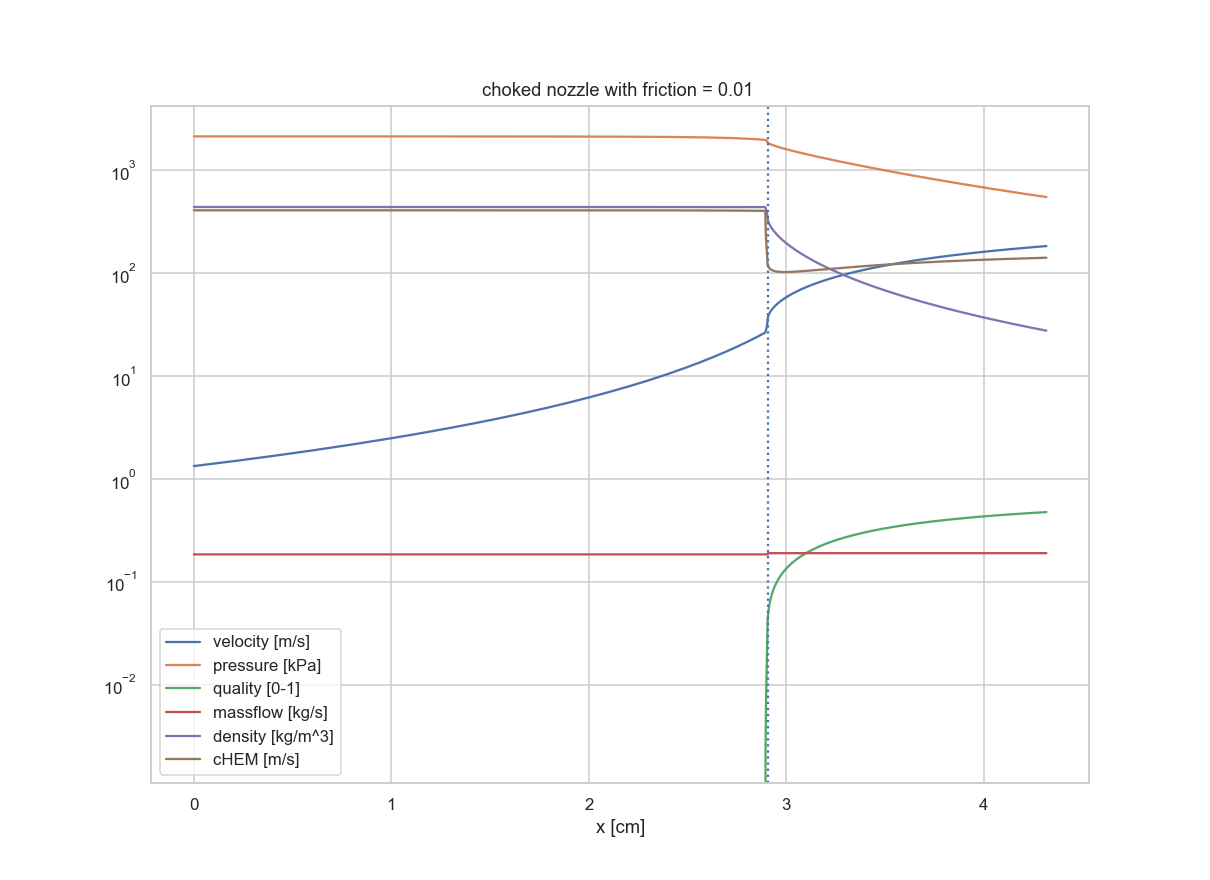

In [9]:
sol_until_throat = nsolver.solveAdaptive1DBasic(vin_crit, pin, hin, 0.0, nsolver.nozzle.xt)
# In[9]:
dv_kick = 2.0
dp_kick = nsolver.pFromV_MassConst(v = sol_until_throat.iloc[-1]["v"], dv = dv_kick, p = sol_until_throat.iloc[-1]["p"], h = sol_until_throat.iloc[-1]["h"])
print(f"mass conserving artificial kick: dv = {dv_kick} m/s, dp = {dp_kick} kPa")
res_crit = nsolver.solveKickedNozzle(vin_crit, pin , hin, kicks = {'v': 1 , 'p': 0})
nsolver.plotsol(res_crit, title = "choked nozzle with friction = {} ".format(nsolver.frictionCoef))

<IPython.core.display.Javascript object>


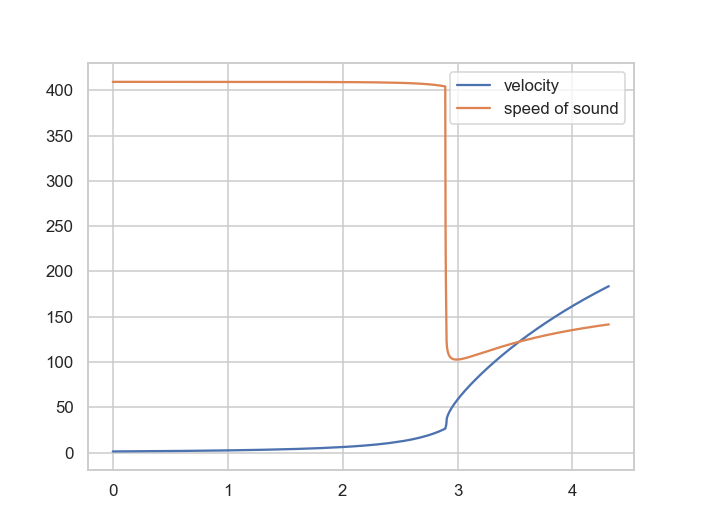

In [10]:
nozzleExit =  res_crit.iloc[-1]
plt.figure()
plt.plot(res_crit['x'], res_crit['v'])
plt.plot(res_crit['x'], res_crit['c'])
plt.legend(["velocity", "speed of sound"])

In [21]:
massFlowPrim = nozzleExit['v']* nozzleExit['d']* nozzle.Aprofile(nozzle.L) * 1e-4
print(f"calculated primary mass flow rate  {round(massFlowPrim, 5)} kg/sec") # in kg/sec

calculated primary mass flow rate  0.19016 kg/sec


# Mixing calculations without normal shocks

In [22]:
mixingParams = { 'massExchangeFactor' : 1.e-4, 'dragFactor': 0.003, 'frictionInterface': 0.001, 'frictionWall': 0.015}
mixer = EjectorMixer.EjectorMixer(fluid, ejector, mixingParams)

Approximated Suction Area = 2 * (2.2cm/2)^2 * \Pi

In [23]:
calcSucMassFlow = True
if calcSucMassFlow == False:
    # Single Choking calculation. With externally set suction mass flow rate:
    MFlowSuc = 58.0
    mixer.setSuctionMassFlow(MFlowSuc) # set the suction mass flow rate in [g/s]b

    entrainment = mixer.massFlowSecond / 1000.0 / massFlowPrim
    entrainment

    preMix = mixer.premixWrapSolve(res_crit, Psuc ,Tsuc)
    preMix
    mixerinput = [ preMix[key] for key in [  'py', 'vpy', 'vsy', 'hpy', 'hsy', 'Apy', 'Asy']]

    solMix = mixer.solveMix(mixerinput)
else:
    mixer.setSuctionMassFlow(None)
    mixer.setSingleChoke(True)
    mixer.ejector.Asi = 2* 1.1**2 * math.pi  # cm2 of the suction nozzle inlet.
    #mixer.ejector.Asi = 2*3.14*3.25*2.2
    preMix = mixer.premixWrapSolve(res_crit, Psuc ,Tsuc)
    preMix
    print(f"calculated secondary mass flow rate {preMix['massFlowSecond']} g/s")
    mixerinput = [ preMix[key] for key in [  'py', 'vpy', 'vsy', 'hpy', 'hsy', 'Apy', 'Asy']]
    solMix = mixer.solveMix(mixerinput)

critical flow nozzle outlet quantities
               1659
x          4.316600
v        183.793416
p        550.507053
h        490.057942
d         27.668970
c        141.572446
mach       1.298229
quality    0.477133
INFO:root:suction flow by inlet Dens 10.272918487074273 g/l, quality 1.0
INFO:root:calculation of single-chocking subcritical mode incl. suction mass flow rate calculations
{'Tsi': 325.84999999999997, 'psi': 430, 'massFlowPrim': 190.15642394038912, 'ho': 490.05794248229677, 'vo': 183.79341625084058, 'so': 1.9208320865813313, 'Am': 1.5393804002589984}
INFO:root:solving equation in solvePreMixSingleChoke with parameters:
 {'Tsi': 325.84999999999997, 'psi': 430, 'massFlowPrim': 190.15642394038912, 'ho': 490.05794248229677, 'vo': 183.79341625084058, 'so': 1.9208320865813313, 'Am': 1.5393804002589984, 'Dsi': 10.272918487074273, 'hsi': 664.5136471770934, 'hst': 664.5136471770934, 'sst': 2.4852077152201244, 'Asi': 7.602654221687301}
INFO:root:premix calculation finished after 1

In [24]:
print(solMix)

             x           p          vp         vs          hp          hs        Ap        As
0     5.514000  413.993500  213.526016  56.480350  484.151276  662.948364  0.462020  1.077361
1     5.696915  417.371119  210.931799  55.990891  484.799968  662.665620  0.464494  1.074887
2     5.879829  420.668145  208.396433  55.524795  485.427997  662.386000  0.467022  1.072359
3     6.062744  423.887388  205.918033  55.080699  486.036257  662.109448  0.469601  1.069780
4     6.245658  427.031514  203.494795  54.657348  486.625597  661.835906  0.472228  1.067152
..         ...         ...         ...        ...         ...         ...       ...       ...
195  41.182342  588.469785   44.827571   3.778381  514.501786  634.120062  1.698289  8.124874
196  41.365256  588.522875   44.562614   3.737855  514.536285  634.027343  1.708814  8.203249
197  41.548171  588.575001   44.299972   3.697956  514.570517  633.934918  1.719375  8.281988
198  41.731085  588.626181   44.039617   3.658670  514.60448

<IPython.core.display.Javascript object>


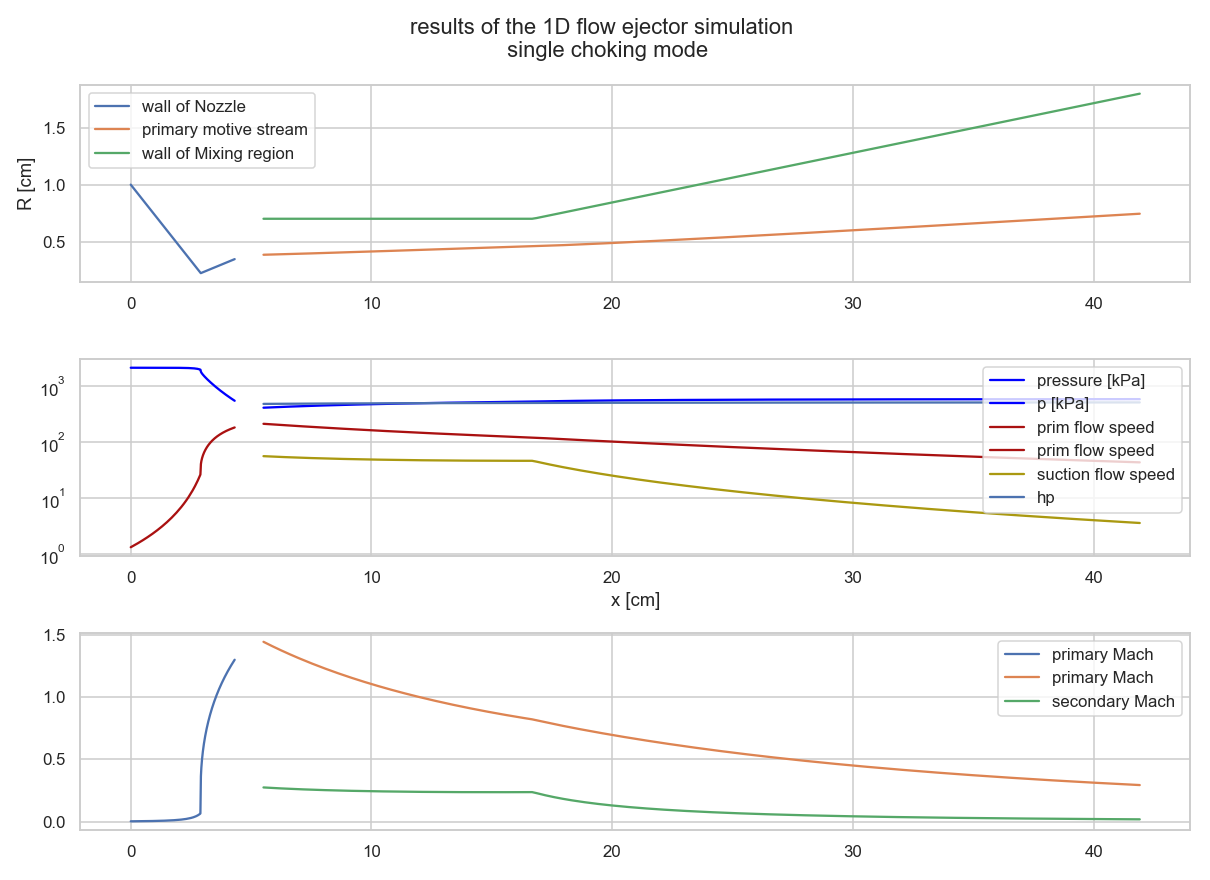

In [25]:
mixer.plotSolution(res_crit, solMix, "single choking mode",  ejectorPlot)

In [26]:
Pdiffout = solMix.iloc[-1]['p']
diffusorLast =  solMix.iloc[-1]
primState =  refProp.getTD(RP, diffusorLast['hp'] , diffusorLast['p'])
secState = refProp.getTD(RP, diffusorLast['hs'] , diffusorLast['p'])
primState, secState
massFPrim = primState['D'] * diffusorLast['vp']* diffusorLast['Ap']* 1e-4
massFSec = primState['D'] * diffusorLast['vs']* diffusorLast['As']* 1e-4
massFPrim , massFSec
efficiency = mixer.calcEfficiency(pin, Tin, Psuc, Tsuc, Pdiffout, massFPrim , massFSec )
print(f"Ejector efficiency {round(efficiency,4)}")

 h = 28514.3659531063
 h = 39386.98668233395
 Expansion work recovered : 1.0613562303854354 Watt. 
  max expansion work recovery potential 3.2860935802664017 Watt
Ejector efficiency 0.323


## solution with shock wave in the mixer:

In [29]:
x_sh= 13.5 # let's say there is a normal shock wave at x_sh cm!
solNoShock = solMix

In [30]:
beforeShock, afterShock, solMixShocked = mixer.mixingShock(x_sh, solNoShock, mergeflows = True)

after the shock starting with v,p,h = [96.82631872366684, 544.3012049511473, 593.3908264588067]
friction of the flow calc set to 0.015
{'massflow': 0.2503580853785193}
INFO:root: x interval end reached xlast 41.90000000000029 +  dX 0.1 vs xend 41.914
INFO:root:solver finished in 414 iterations. final point xlast =41.914
       x          v           p           h          d           c      mach   quality
0  13.50  96.826319  544.301205  593.390826  16.796634  178.902062  0.541225  0.793614
1  13.52  96.847740  544.198870  593.388752  16.792918  178.906368  0.541332  0.793645
2  13.54  96.869178  544.096493  593.386676  16.789202  178.910675  0.541439  0.793675
3  13.56  96.890632  543.994074  593.384597  16.785484  178.914985  0.541546  0.793706
4  13.58  96.912103  543.891613  593.382517  16.781766  178.919295  0.541653  0.793736


c:\users\buruzsa\pycharmprojects\environments\simpyejector\lib\site-packages\simpy_ejector\EjectorMixer.py:621: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solMixShocked = shockUpStream.append(afterP, ignore_index=True)


<IPython.core.display.Javascript object>


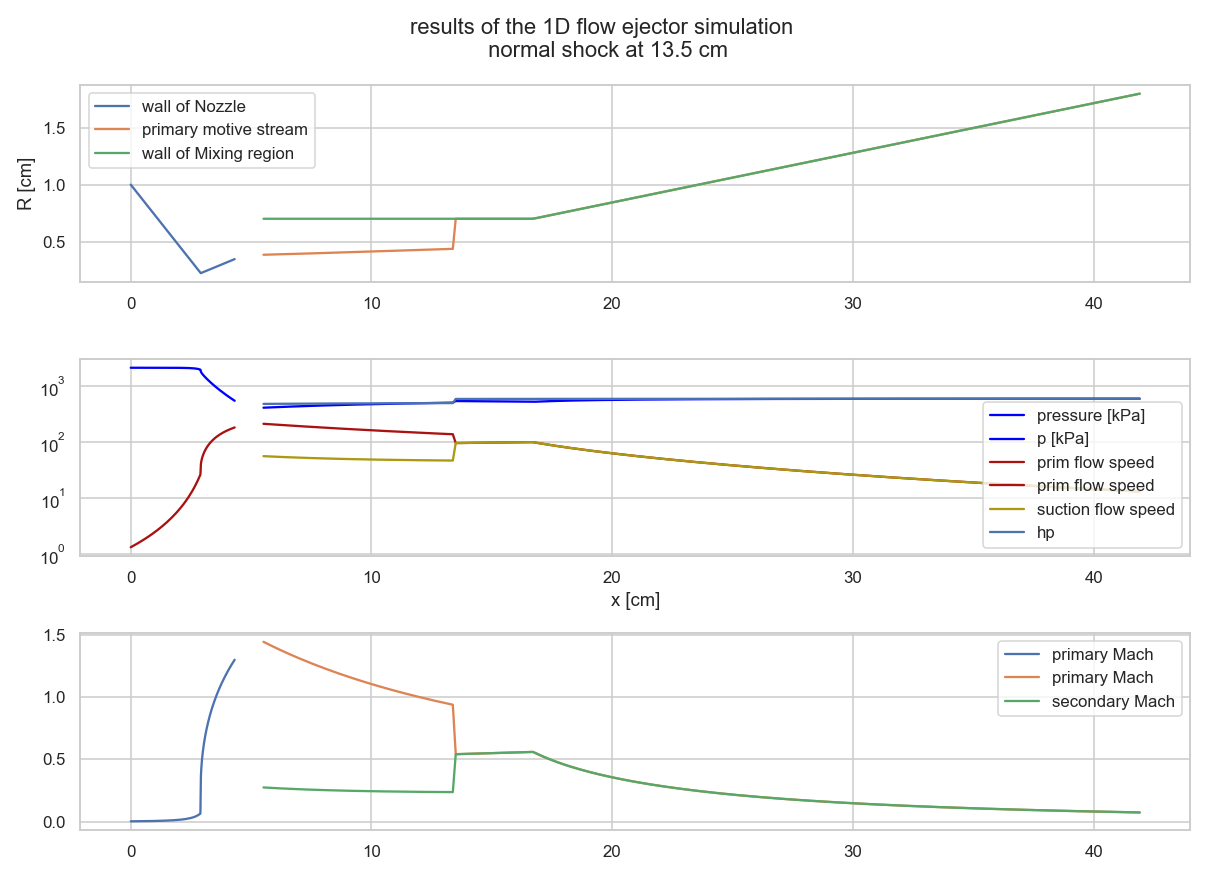

In [31]:
mixer.plotSolution(res_crit, solMixShocked, "normal shock at {} cm".format(x_sh),  ejectorPlot)

#### so the shock at x_sh kicks the flow down to subsonic region.
#### the values at the diffuser exit:

In [32]:
solMixShocked.iloc[-1]
# x in cm, p in kPa, vp/vs = primary/secondary speed in m/s, hp, hs in kJ/kg/K, Ap,As in cm^2 

x      41.914000
p     600.415538
vp     13.209138
vs     13.209138
hp    597.991254
hs    597.991254
Ap     10.178760
As      0.000000
Name: 457, dtype: float64